# Analysis of scRNA-seq data from activated PBMCs in TWINS only

In CVID and healthy control, 10X platform

# B cell populations only (as annotated in M4 notebook & cleaned up in M5)

16.02.2021: reanalysis, correcting the bug in bertie function

(Preprocessing happened in notebook M1)

Step-by-step workflow - **different to the scRNA-seq integration in doublet calling**:
- load preprocessed object
- do SCTransfor instead of normalising & log transforming
- save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- filter out cell cycle genes
- subset to HVGs
- (skipping scaling, not necessary because we've done SCTransform)
- pca (can also do preliminary neighbors/bbknn+umap here to peak at the data)
- **train a logreg model and add annotation (before it used to be earlier in the workflow)**
- neighbors/bbknn - deciding on which batch correction we will be using
- perform **step 2** of bertie doublet calling (requires running louvain clustering, see code)
- umap
- unbiased clustering
- save

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# need to do 'pip3 install bbknn==1.3.8' to avoid incompatibility errors
import bbknn
# requires 'pip install scrublet'
#import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.6.2
airr==1.3.1
alembic==1.3.0
anndata==0.7.5
annoy==1.16.2
async-generator==1.10
async-timeout==3.0.1
attrs==19.3.0
backcall==0.1.0
bbknn==1.3.6
bleach==3.1.0
blinker==1.4
CellPhoneDB==2.1.5
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
click==6.7
conda==4.7.12
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
Cython==0.29.14
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fbpca==1.0
geosketch==0.3
get-version==2.1
h5py==2.10.0
idna==2.7
imageio==2.9.0
importlib-metadata==0.23
intervaltree==2.1.0
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
jedi==0.15.1
Jinja2==2.10.3
joblib==0.14.0
json5==0.8.5
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
jupyter-rsession-proxy==1.0b6
jupyter-server-proxy==1.2.0
jupyterhub==1.0.0
jupyterlab==1.2.1
jupyterlab-server==1.0.6
kiwisolver==1.1.0
legacy-api-wrap==1.2
leidenalg==0.7.0
llvmlite==0.30.0
loompy==3.0.6
louvain==0.6.1
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.3.4
mistune==0.8

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
annoy               NA
attr                19.3.0
backcall            0.1.0
bbknn               NA
cffi                1.13.2
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.1
get_version         2.1
h5py                2.10.0
highs_wrapper       NA
igraph              0.7.1
importlib_metadata  0.23
ipykernel           5.1.3
ipython_genutils    0.2.0
jedi                0.15.1
joblib              0.14.0
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.30.0
louvain             0.6.1
matplotlib          3.3.4
more_itertools      NA
mpl_toolkits        NA
natsort             6.2.0
numba               0.46.0
numexpr             2.7.0
numpy               1.17.4
packaging           19.2
pandas              0.25.3
parso               0.5.1
pexpect        

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

## Reding the preprocessed object

Preprocessing happened in M1 notebook

In [6]:
# reading
adata = sc.read(save_path+'adata_raw_filtered.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 17662 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

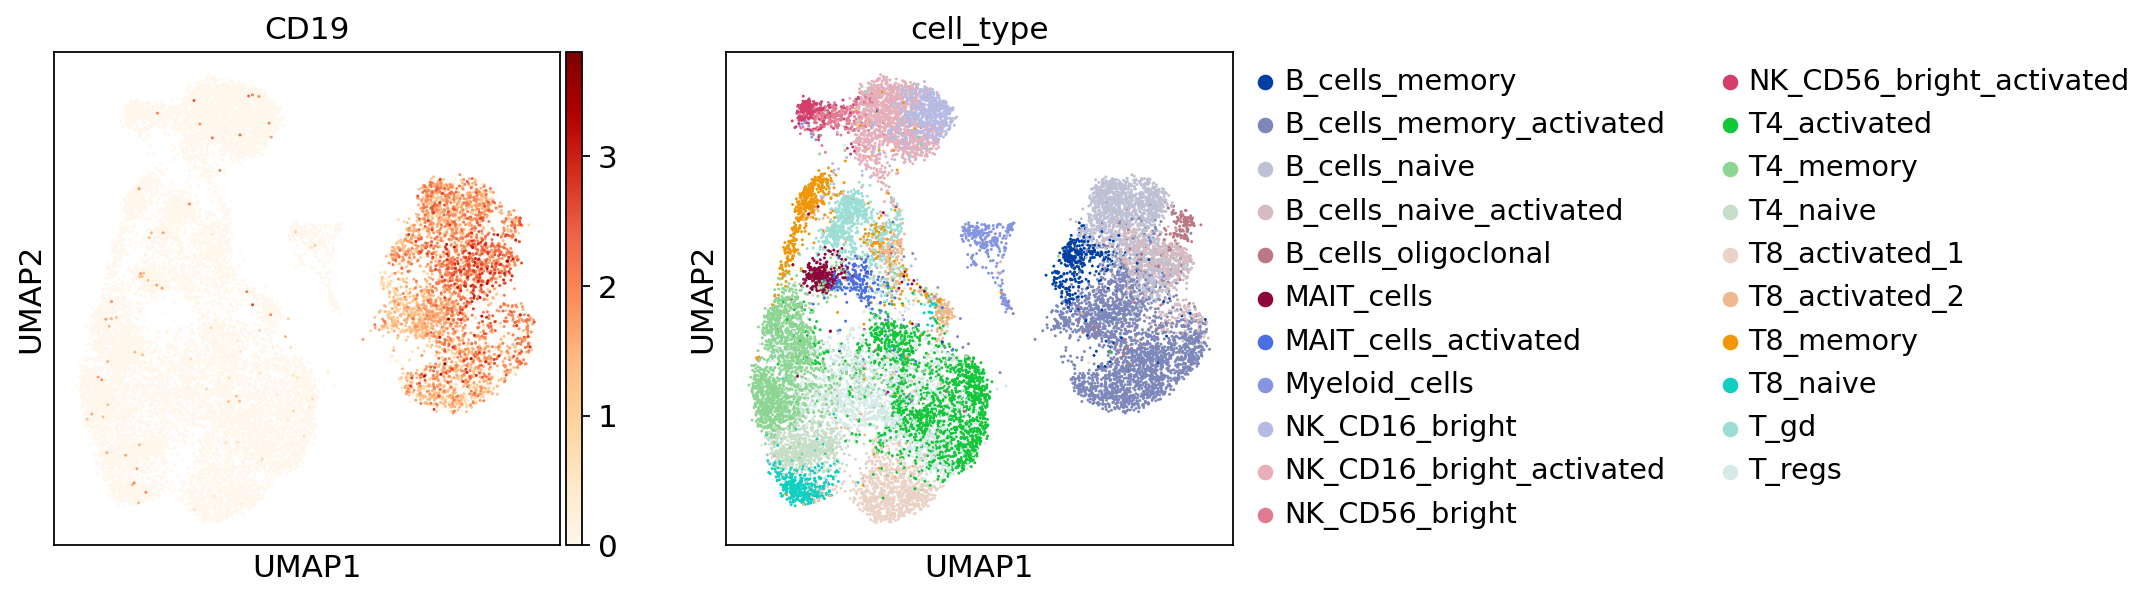

In [10]:
# reading object analysed in M2 notebook with louvain cluster labels - I need clusters 1 and 3 - those are B cells
adata_with_annot = sc.read(save_path + 'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_final_manifold_with_annotation.h5ad')
sc.pl.umap(adata_with_annot, color=['CD19',
                                     'cell_type'], 
           cmap='OrRd', use_raw=True, ncols=2)

In [11]:
np.unique(adata_with_annot.obs['cell_type'], return_counts=True)

(array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
        'B_cells_naive_activated', 'B_cells_oligoclonal', 'MAIT_cells',
        'MAIT_cells_activated', 'Myeloid_cells', 'NK_CD16_bright',
        'NK_CD16_bright_activated', 'NK_CD56_bright',
        'NK_CD56_bright_activated', 'T4_activated', 'T4_memory',
        'T4_naive', 'T8_activated_1', 'T8_activated_2', 'T8_memory',
        'T8_naive', 'T_gd', 'T_regs'], dtype=object),
 array([ 391, 2472, 1568,  696,  196,  299,  219,  285,  763, 1235,  238,
         200, 1739, 1772,  675,  830,  288,  558,  408,  697, 1576]))

In [12]:
B_cell_indices = list(adata_with_louvain[adata_with_louvain.obs['cell_type'].isin(['B_cells_memory', 
                                                                                 'B_cells_memory_activated', 
                                                                                 'B_cells_naive',
                                                                                 'B_cells_naive_activated', 
                                                                                 'B_cells_oligoclonal'])].obs_names)
len(B_cell_indices)

5323

In [13]:
# subsetting the adata to only B cells
adata = adata[B_cell_indices,:].copy()

In [14]:
adata

AnnData object with n_obs × n_vars = 5323 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

In [15]:
np.unique(adata.obs['sample'])

array(['Immunodeficiency8103070', 'Immunodeficiency8103072',
       'Immunodeficiency8103073', 'Immunodeficiency8103074',
       'Immunodeficiency8103076', 'Immunodeficiency8103077'], dtype=object)

In [16]:
# quick check to see if the values are integer
expr_mtx_protein = adata[adata.obs['sample'] == 'Immunodeficiency8103070'].X.todense()
np.unique(expr_mtx_protein)

matrix([[  0.,   0.,   0., ..., 437., 490., 536.]], dtype=float32)

In [17]:
adata

AnnData object with n_obs × n_vars = 5323 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

_____________________________________________________________________________________________________________________________________________________________

Carrying on to 
- Normalise and log transform
- Save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- Make cell names (obs) and gene names (var) unique

In [18]:
# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


___________

### Filter Cell cycle genes 
Per genes analysis: identify genes behaving like known cell cycle genes


extracting highly variable genes
    finished (0:00:00)


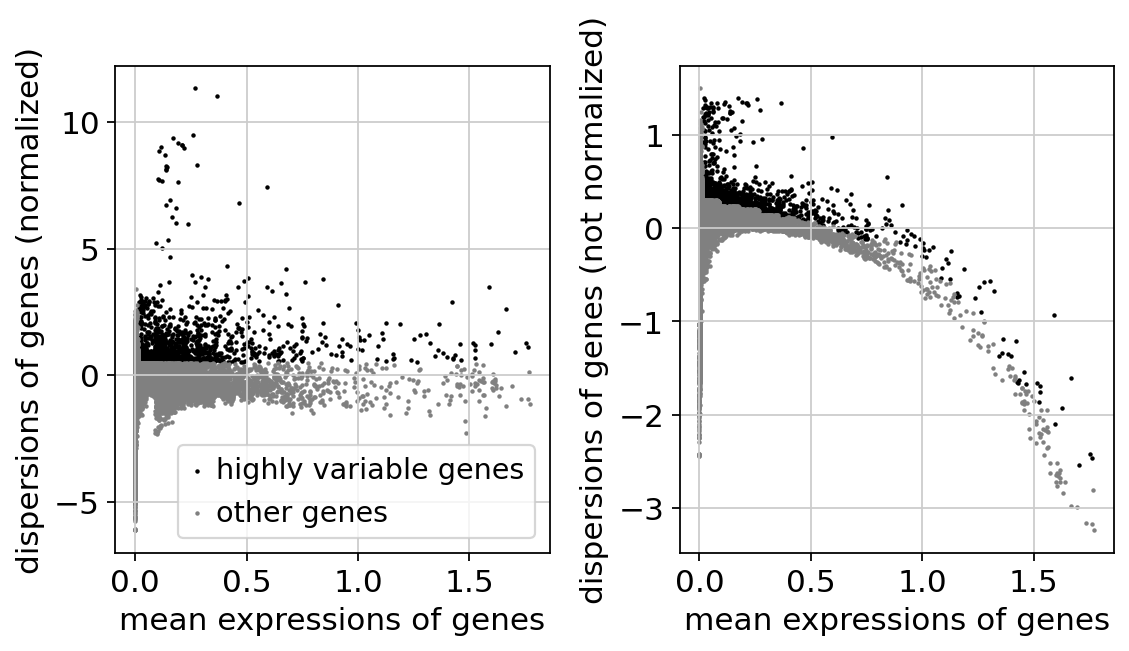

In [19]:
# getting only GEX data
cellcycle_adata = adata[:,adata.var['feature_types-0'] != 'Antibody Capture'].copy()
# Extract highly variable genes
filter_result = sc.pp.filter_genes_dispersion(
    cellcycle_adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result,save='_ccg_identification.pdf')

In [20]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]


In [21]:
%%time
# Scale data to unit variance and zero mean
sc.pp.scale(cellcycle_adata, max_value=10)
# Scatter plot in PCA coordinates
sc.tl.pca(cellcycle_adata, n_comps=30)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=30
    finished (0:00:00)
CPU times: user 3.42 s, sys: 5.32 s, total: 8.74 s
Wall time: 883 ms


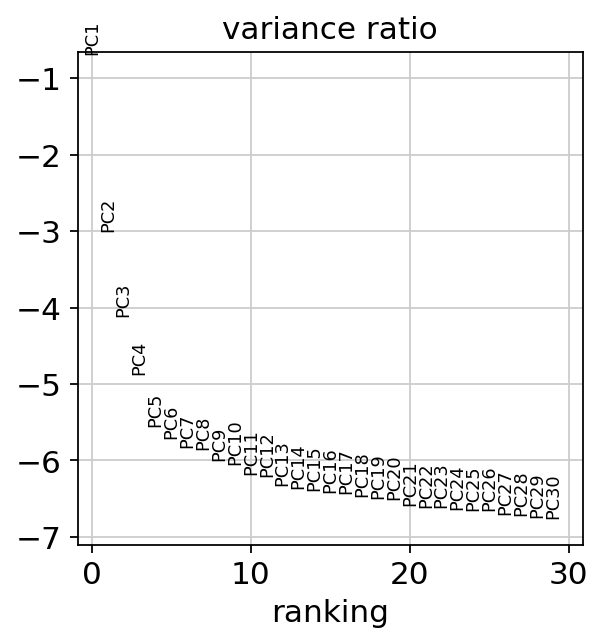

In [22]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True, save='_ccg_identification.pdf')

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


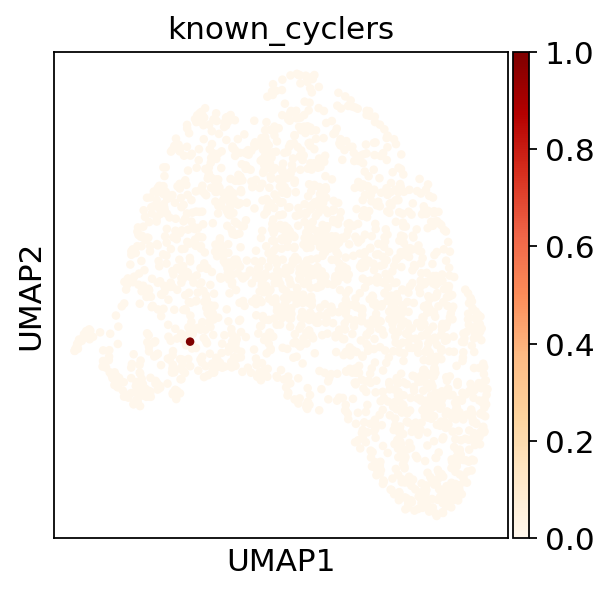

In [24]:
# Identify genes behaving like cc genes
num_pcs = 5
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers'],color_map='OrRd',save='_ccg_identification.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


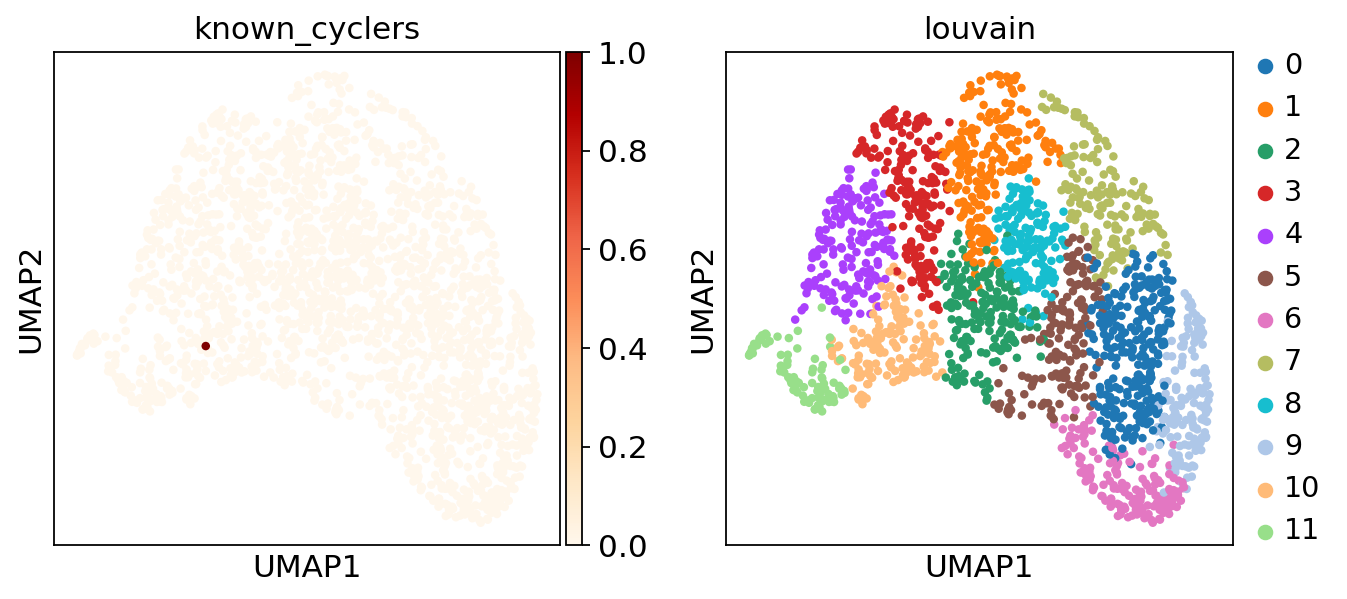

In [25]:
# Cluster GENES into subgroups using louvain
sc.tl.louvain(cellcycle_adata, resolution=1.0)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers',
                                  'louvain'],color_map='OrRd',save='_ccg_identification.pdf')

In [26]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[['CDK1','MKI67','CCNB2','PCNA'],'louvain'])


index
CDK1     NaN
MKI67    NaN
CCNB2    NaN
PCNA      10
Name: louvain, dtype: category
Categories (12, object): [0, 1, 2, 3, ..., 8, 9, 10, 11]


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [27]:
adata

AnnData object with n_obs × n_vars = 5323 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'log1p'

Not removing any genes here

In [28]:
adata

AnnData object with n_obs × n_vars = 5323 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'log1p'

In [29]:
%%time
# Assign cell cycle stage & scores
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/notebooks/Vento_Lab/regev_lab_cell_cycle_genes_from_Luz_20200505.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

# takes a few minutes

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    585 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    750 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
CPU times: user 304 ms, sys: 0 ns, total: 304 ms
Wall time: 303 ms


In [31]:
adata

AnnData object with n_obs × n_vars = 5323 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'log1p'

_______________________________________________________________________________________________________

# Subsetting to HVGs and scaling

In [32]:
%%time
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 996 ms, sys: 0 ns, total: 996 ms
Wall time: 996 ms


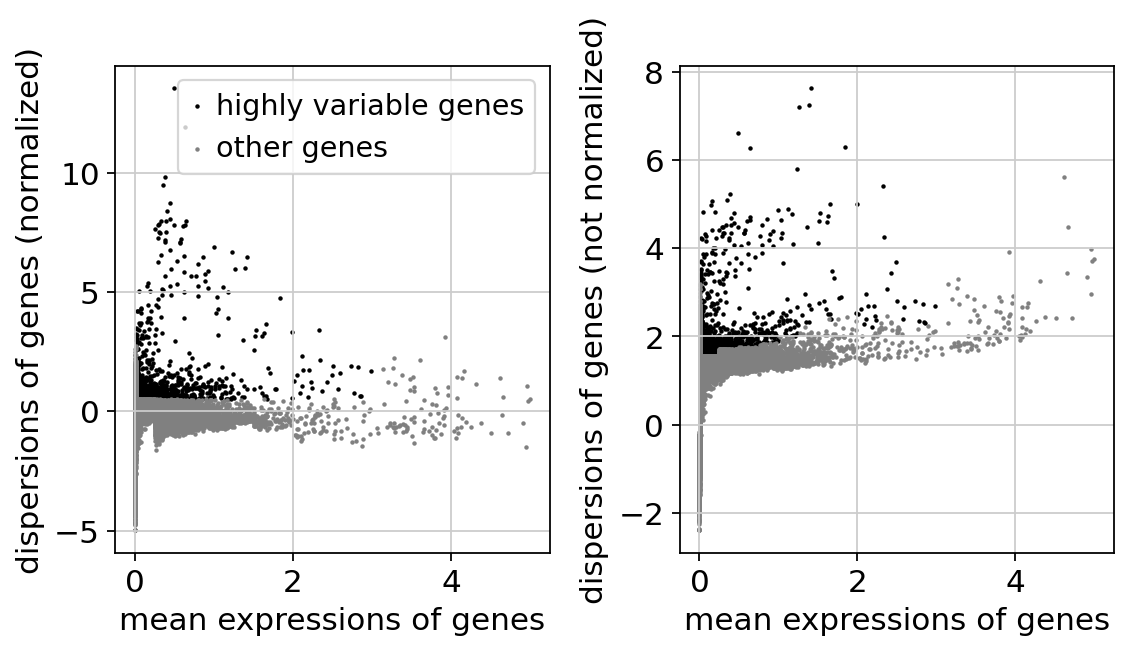

CPU times: user 660 ms, sys: 0 ns, total: 660 ms
Wall time: 660 ms


In [33]:
%%time
sc.pl.highly_variable_genes(adata)

In [34]:
adata_hvg = adata[:, adata.var['highly_variable']]

In [35]:
adata_hvg

View of AnnData object with n_obs × n_vars = 5323 × 2804
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [36]:
%%time
sc.pp.scale(adata_hvg, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 220 ms, sys: 84 ms, total: 304 ms
Wall time: 303 ms


________

## PCA

In [37]:
%%time
sc.tl.pca(adata_hvg, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
CPU times: user 12.9 s, sys: 22.9 s, total: 35.8 s
Wall time: 2.62 s


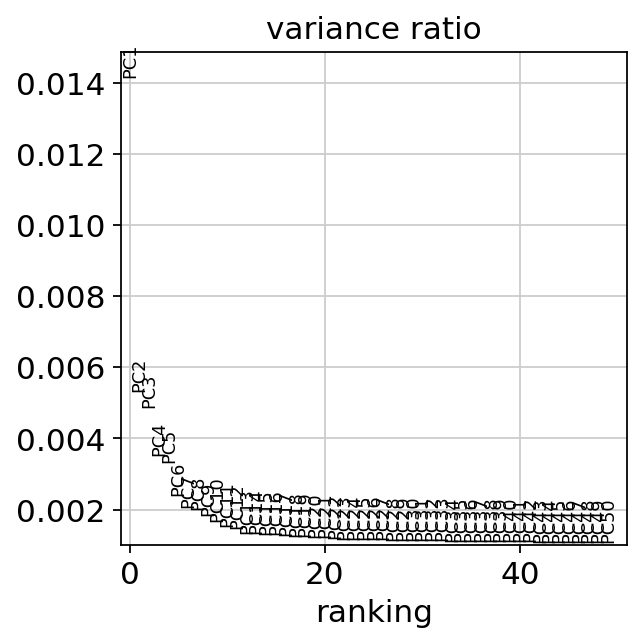

In [38]:
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50)

__________________________________________________________________________________________________________________________________________________________________

### Neighbourhood graph & UMAP

In [38]:
%%time
sc.pp.neighbors(adata_hvg, n_neighbors=10, n_pcs=13)

computing neighbors
    using 'X_pca' with n_pcs = 13
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
CPU times: user 1.8 s, sys: 4.47 s, total: 6.26 s
Wall time: 825 ms


### OR

BBKNN by donor


In [39]:
%%time
bbknn.bbknn(adata_hvg, batch_key='sample')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:02)
CPU times: user 2.12 s, sys: 0 ns, total: 2.12 s
Wall time: 2.12 s


/opt/conda/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/opt/conda/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


__________________________________________________________________________________________________________________________________________________________________

In [40]:
%%time
sc.tl.umap(adata_hvg, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
CPU times: user 14.2 s, sys: 1.52 s, total: 15.7 s
Wall time: 13.7 s


# Plotting

In [41]:
adata_hvg

AnnData object with n_obs × n_vars = 5323 × 2804
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [42]:
markers = ['CD4','CD3G', 'FOXJ1', 'IL2R', 'TRDV2', 'CD8', # T cells
                             'CD19', 'MS4A1', # B cells
                              'CD27', 'CD38', 'JCHAIN', # Plasma B cells
                             'NCAM1', 'FCGR3A', # NK celss
                             'HBB', # Erythrocytes
                             'FCGR3B', # Neutrophils
                             'CD14', 'S100A12', # Monocytes
                             'FLT3', # Dendritic cells
                             'IRF4', 'CLEC9A', # cDC1
                             'CD1C', # cDC2
                             'TNFRSF21', # pDC and IRF4
                             'CD34', # Precursors
                             'PPBP', 'TUBB1', 'PF4', # Platelets
                             'MI67', # cycling
                            ]

### BBKNN by `sample`

... storing 'phase' as categorical


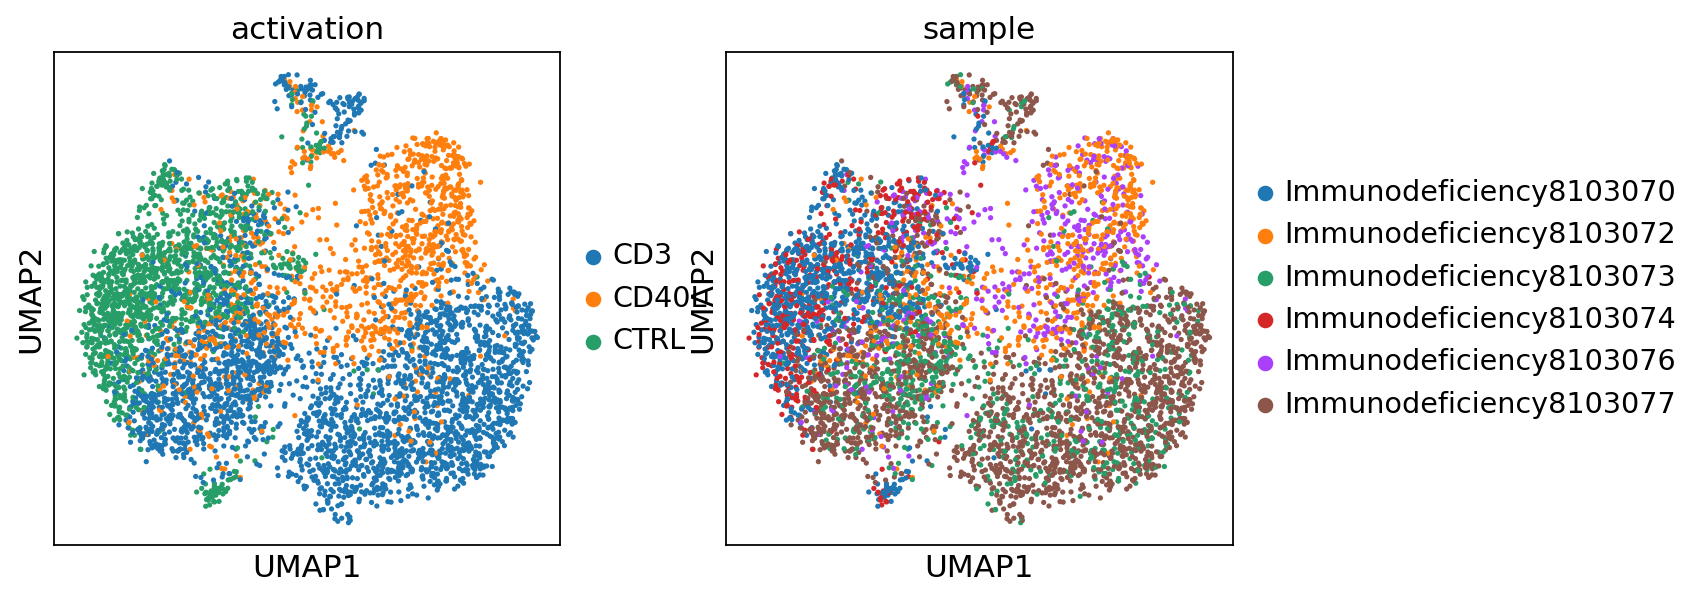

In [43]:
sc.pl.umap(adata_hvg, color=['activation','sample'])

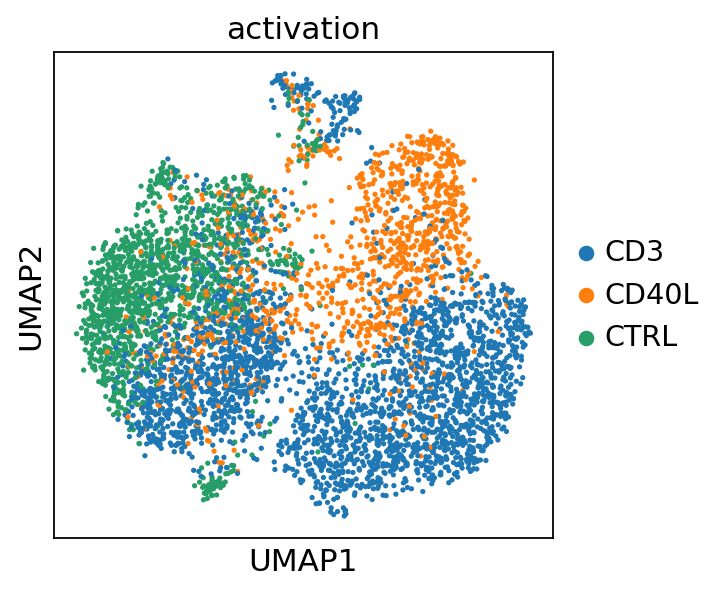

In [44]:
sc.pl.umap(adata_hvg, color=['activation'])

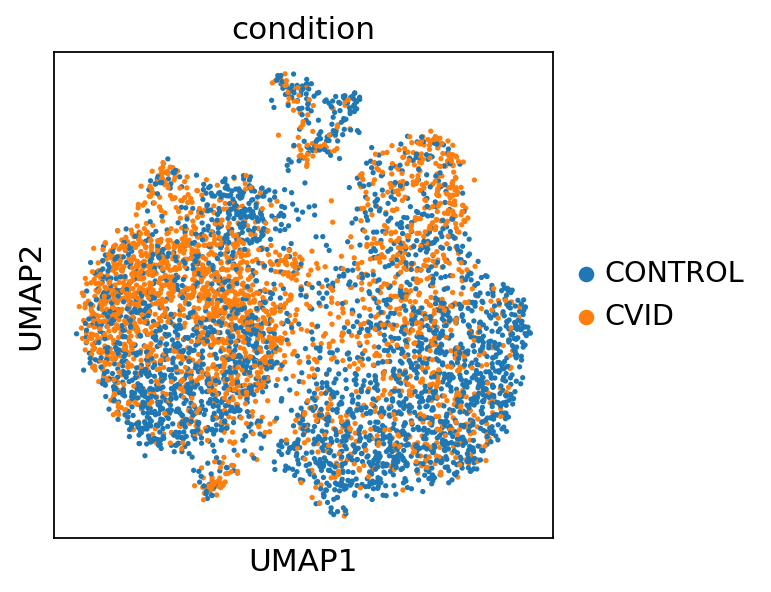

In [45]:
sc.pl.umap(adata_hvg, color=['condition'])

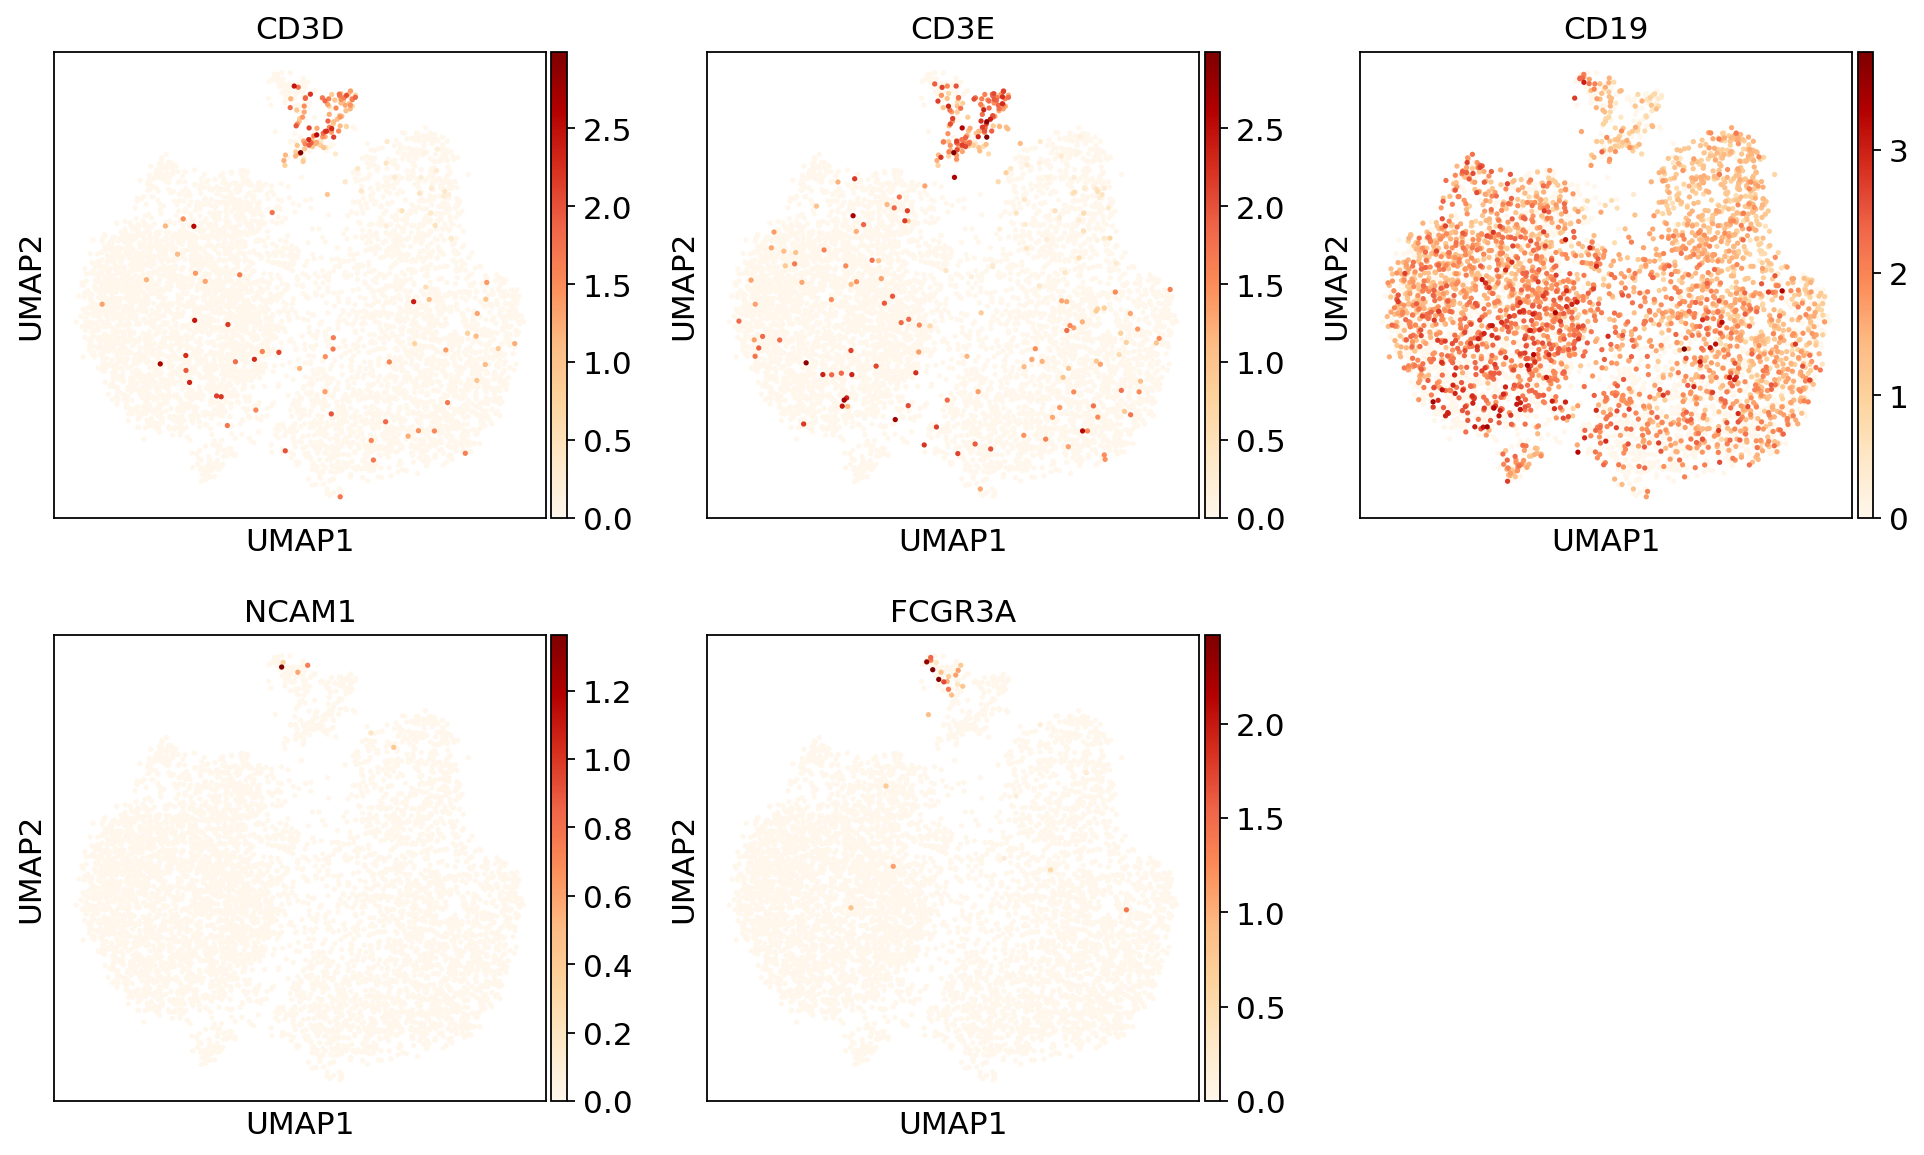

In [61]:
sc.pl.umap(adata_hvg, color=['CD3D', 'CD3E', # T cells
                             'CD19', # B cells
                             # NK markers
                             'NCAM1', # CD56
                             'FCGR3A', # CD16
                            ], ncols=3, use_raw=True, cmap='OrRd')

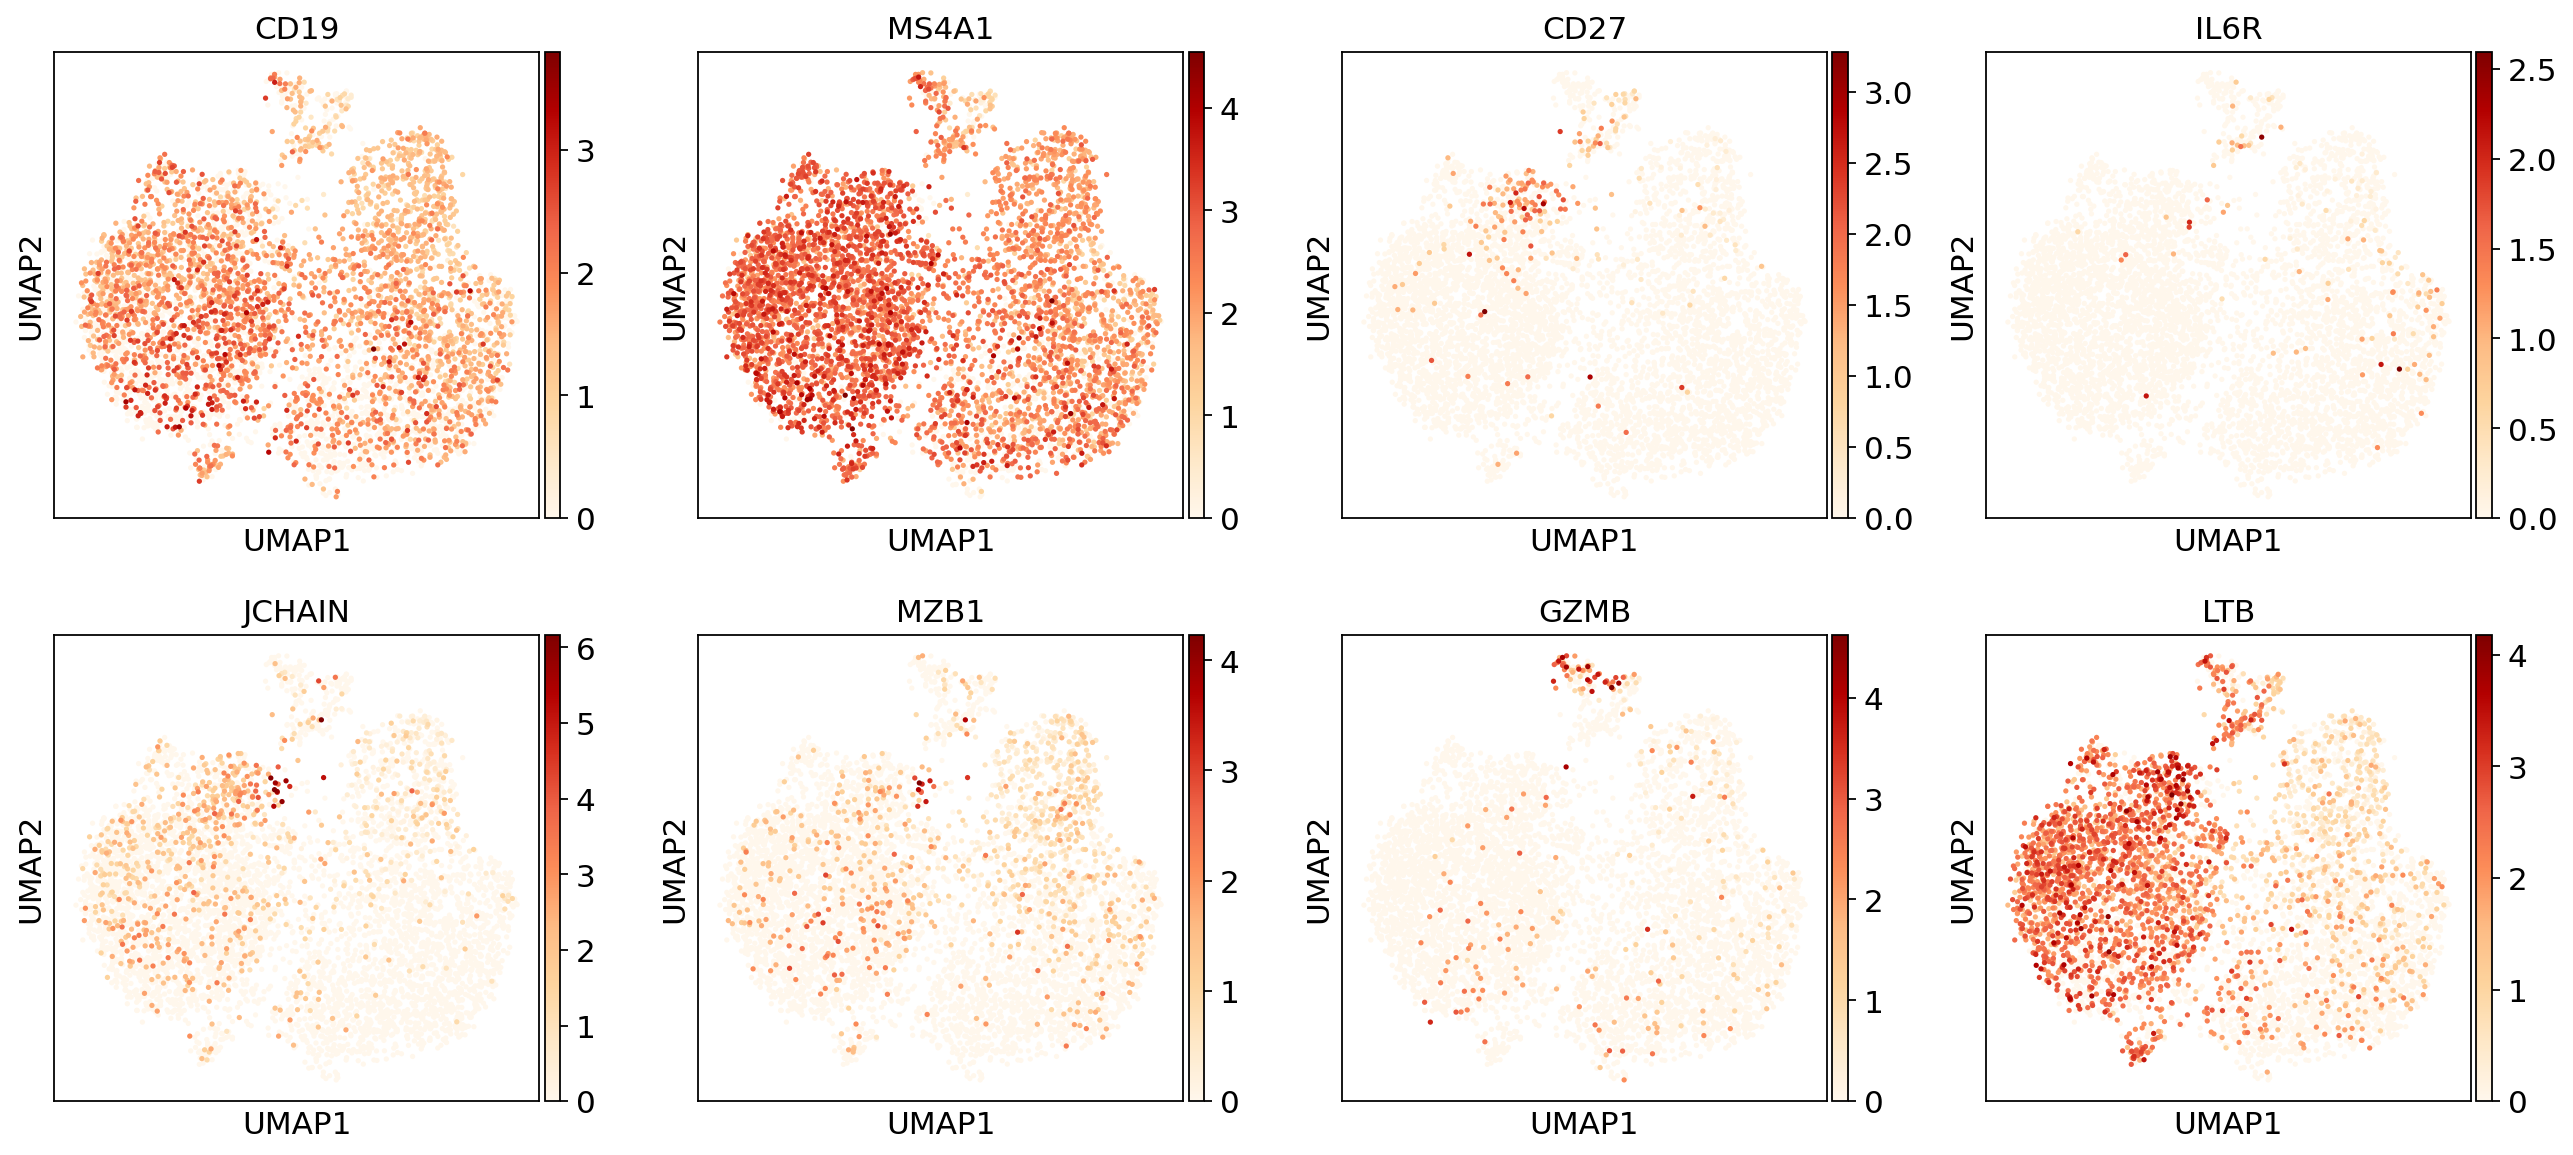

In [47]:
sc.pl.umap(adata_hvg, color=['CD19', # B cells
                                     'MS4A1', # CD20, B cells
                                     #'SDC1', # CD138, Plasma cells
                                     #'CDW78', # CD78
                                     'CD27', 'IL6R', # Plasma cells
                             'JCHAIN', 'MZB1', # Plasma cells
                             'GZMB', 'LTB', # expr in pDC but not Plasma cells
                            #'celltype_predictions',
                            ], 
           cmap='OrRd', use_raw=True,
          )

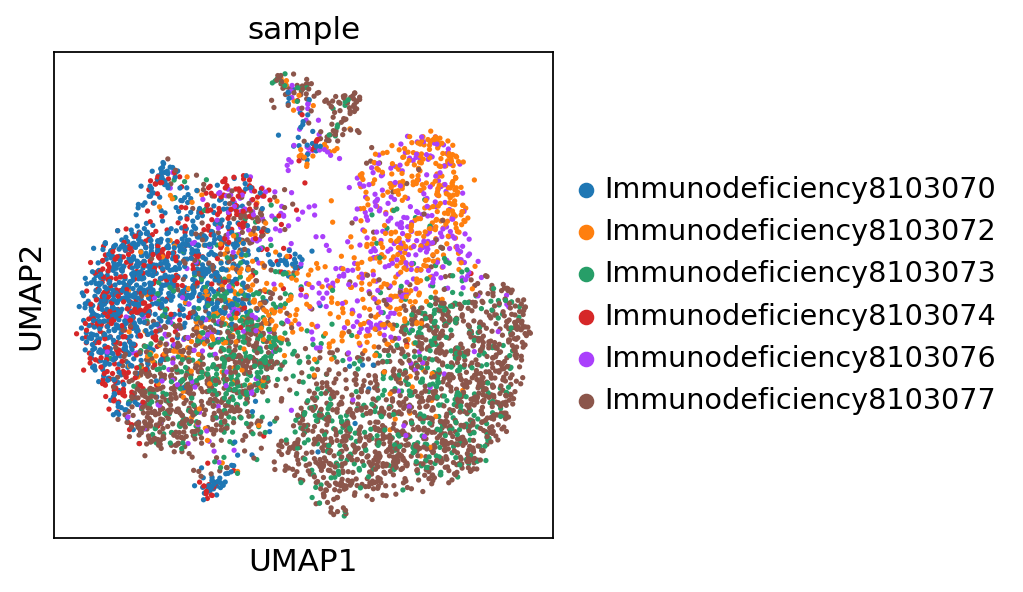

In [48]:
sc.pl.umap(adata_hvg, color=['sample'])

In [56]:
adata_hvg.obs['cell_type'] = adata_with_annot.obs.loc[adata_hvg.obs_names, 'cell_type']

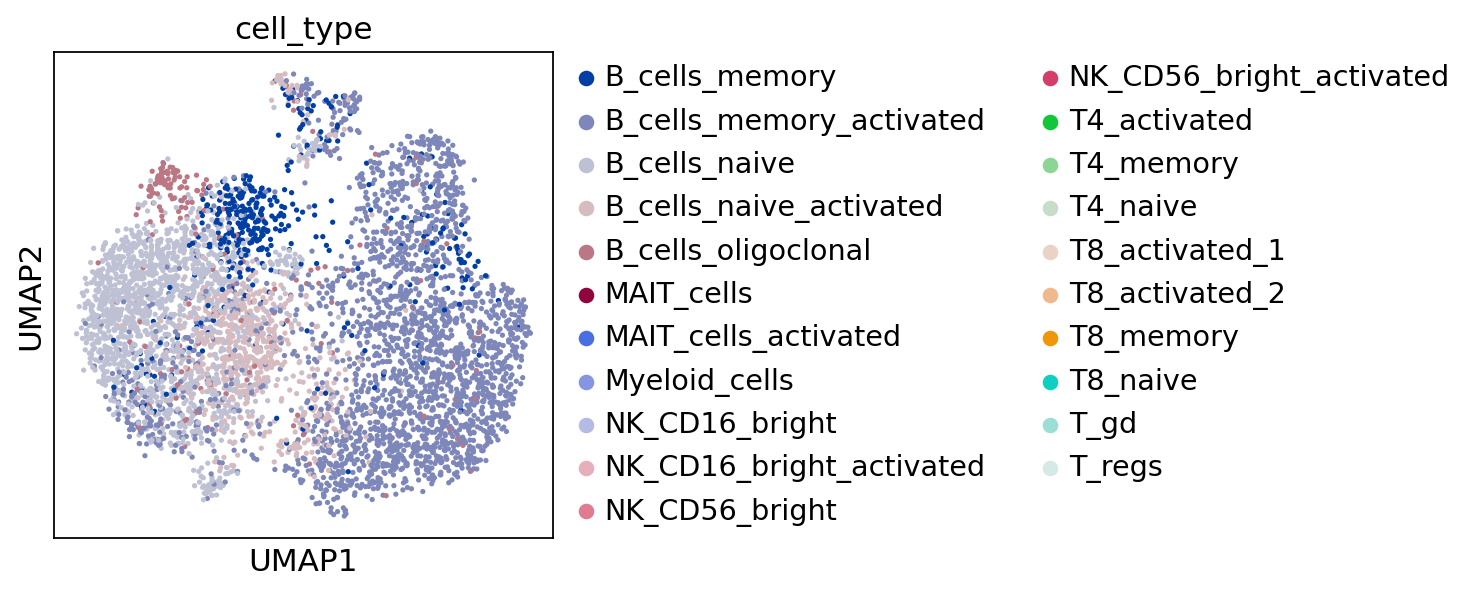

In [57]:
sc.pl.umap(adata_hvg, color=['cell_type'])

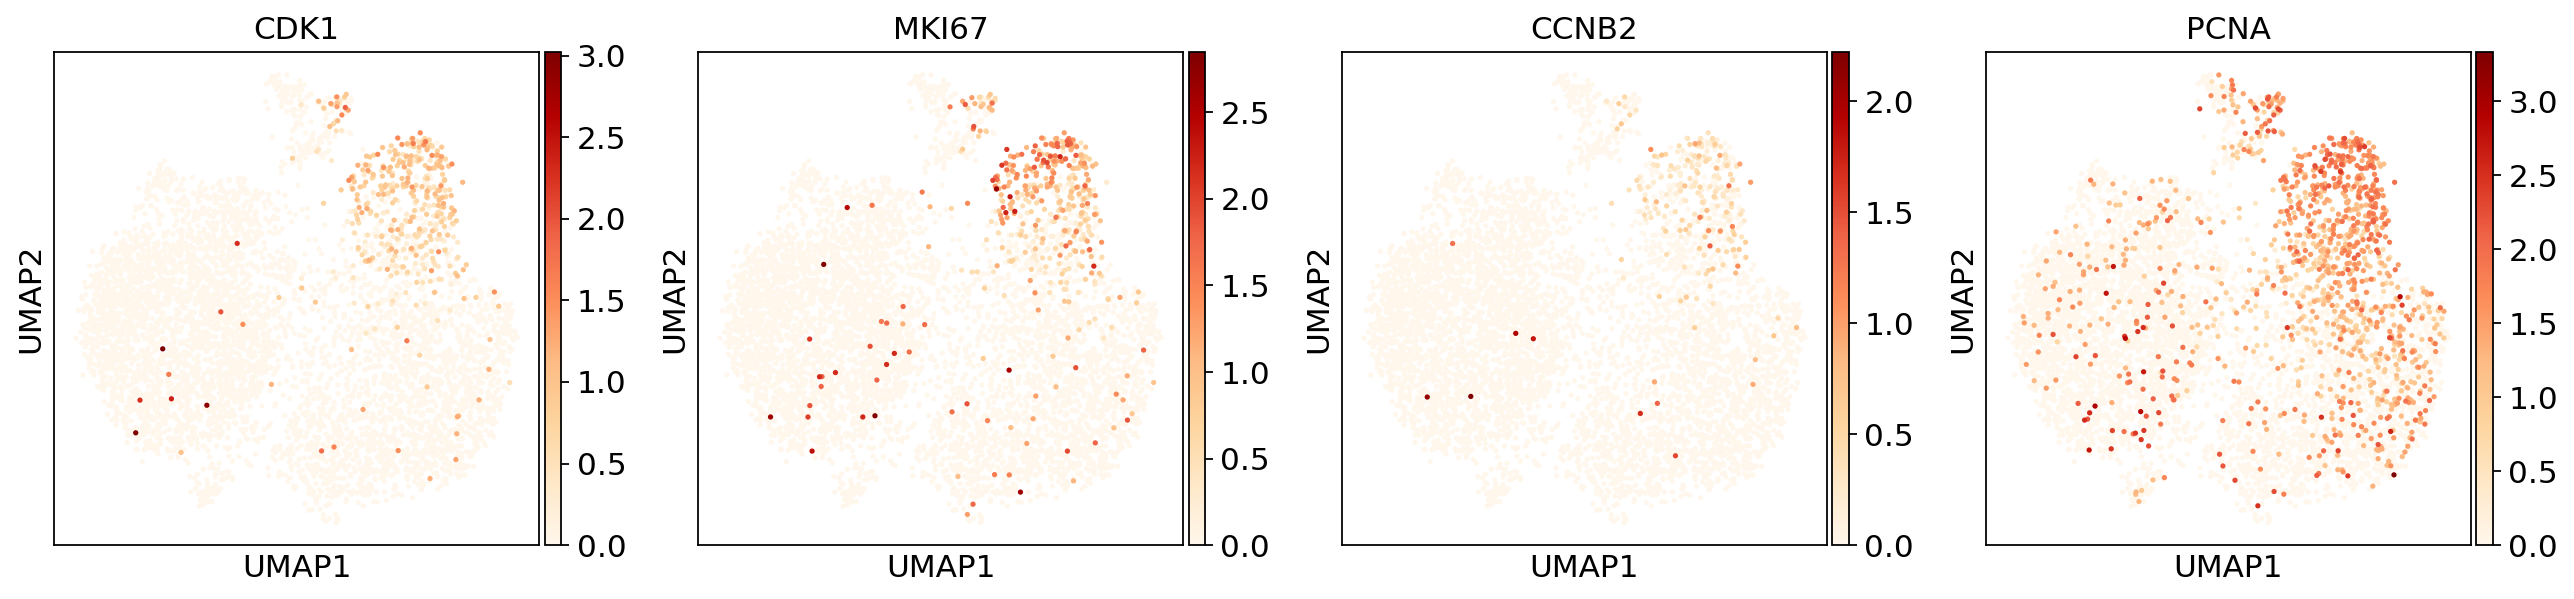

In [49]:
sc.pl.umap(adata_hvg, color=['CDK1','MKI67','CCNB2','PCNA'], cmap='OrRd')

In [50]:
adata_hvg

AnnData object with n_obs × n_vars = 5323 × 2804
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'activation_colors', 'sample_colors', 'condition_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

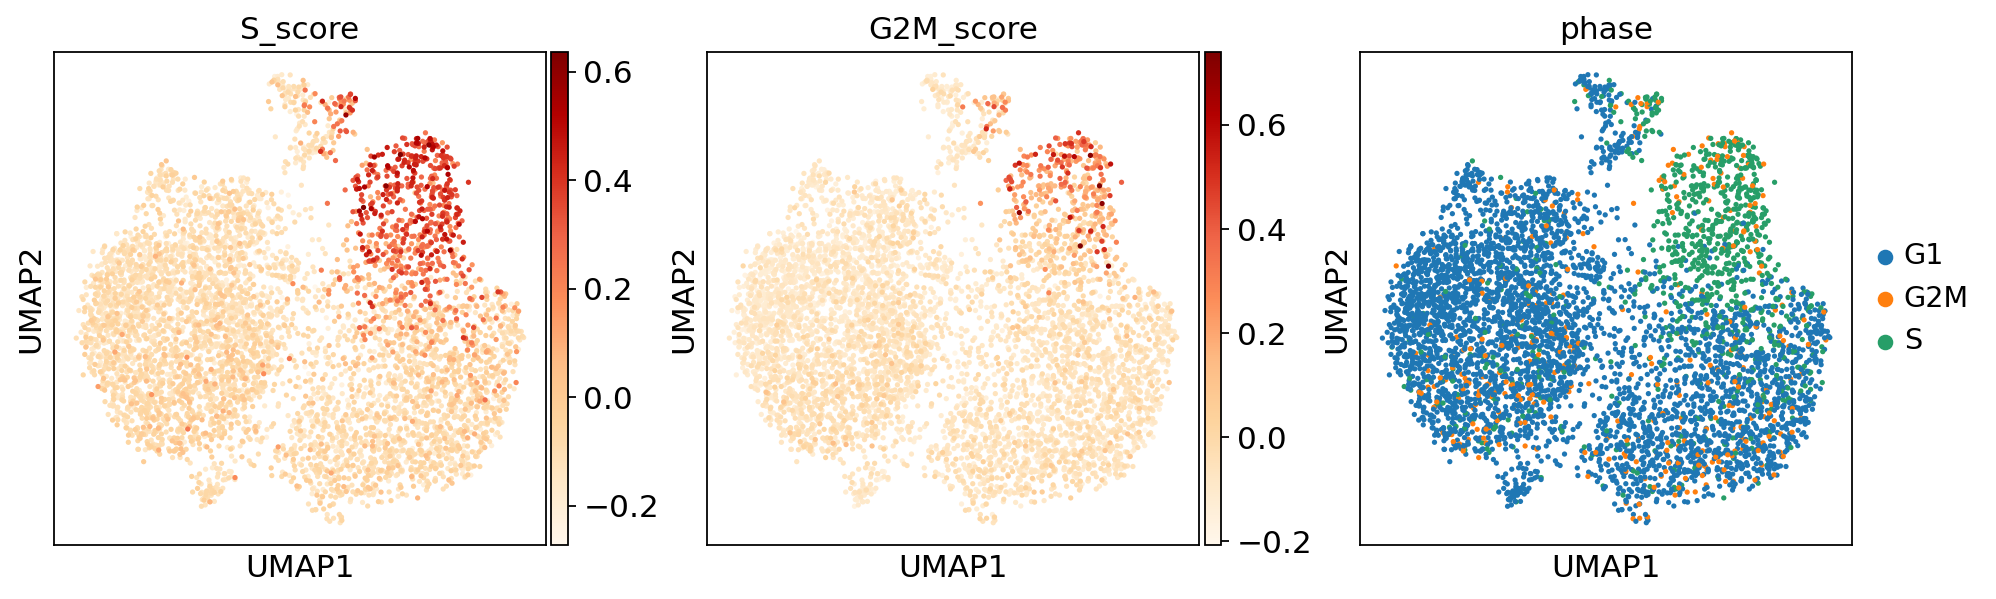

In [51]:
sc.pl.umap(adata_hvg, color=['S_score','G2M_score','phase'], cmap='OrRd')

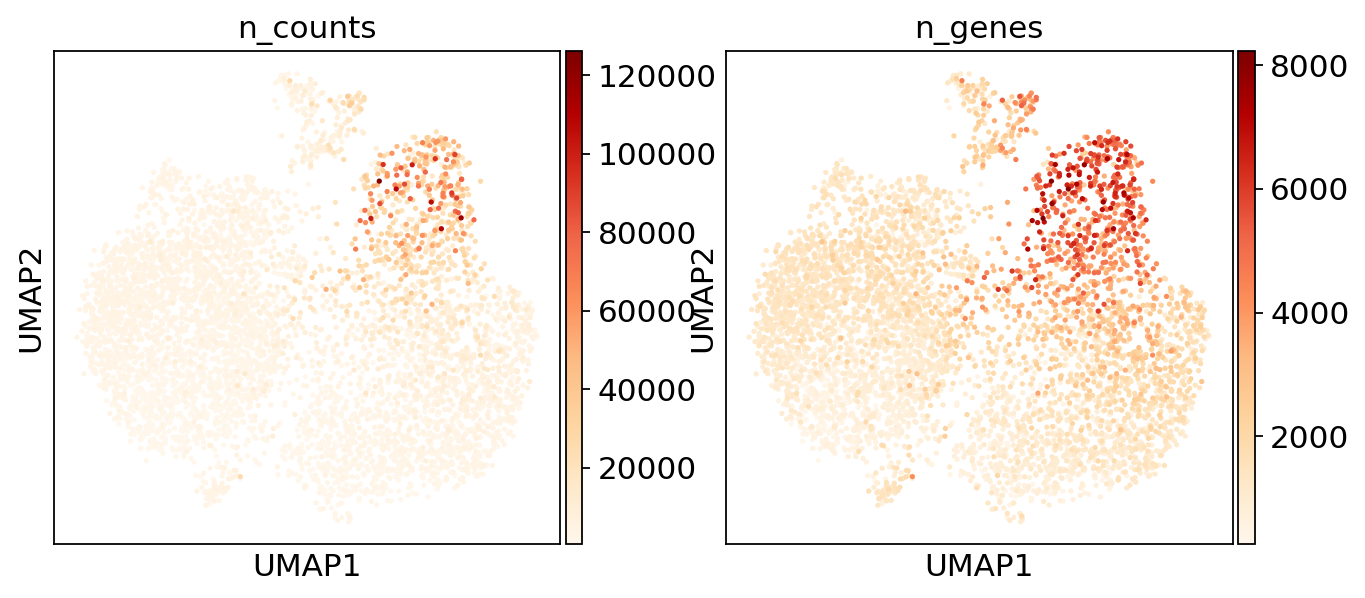

In [52]:
sc.pl.umap(adata_hvg, color=['n_counts',
                             'n_genes'], cmap='OrRd')

## Unbiased clustering


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


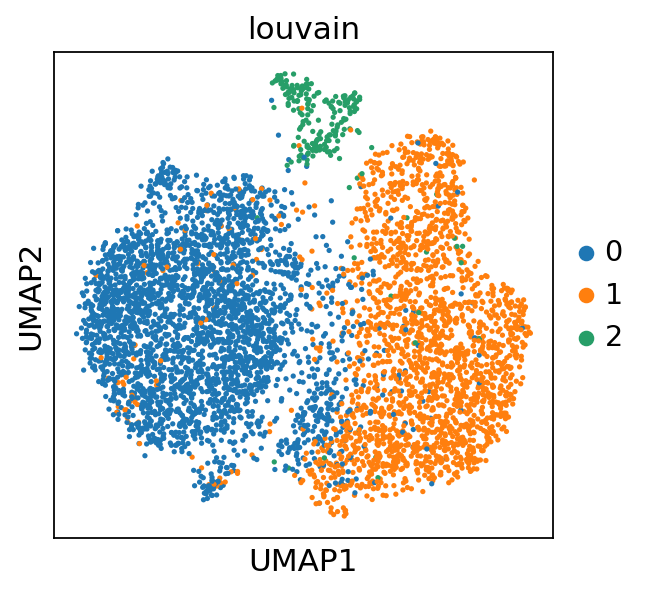

In [59]:
sc.tl.louvain(adata_hvg, resolution=0.5)
sc.pl.umap(adata_hvg, color='louvain')

In [64]:
np.unique(adata_hvg.obs['louvain'], return_counts=True)

(array(['0', '1', '2'], dtype=object), array([3027, 2092,  204]))

In [66]:
adata_with_annot.obs['B_cell_louvain'] = [adata_hvg.obs.loc[barcode, 'louvain'] if barcode in adata_hvg.obs_names else 'none' for barcode in adata_with_annot.obs_names]

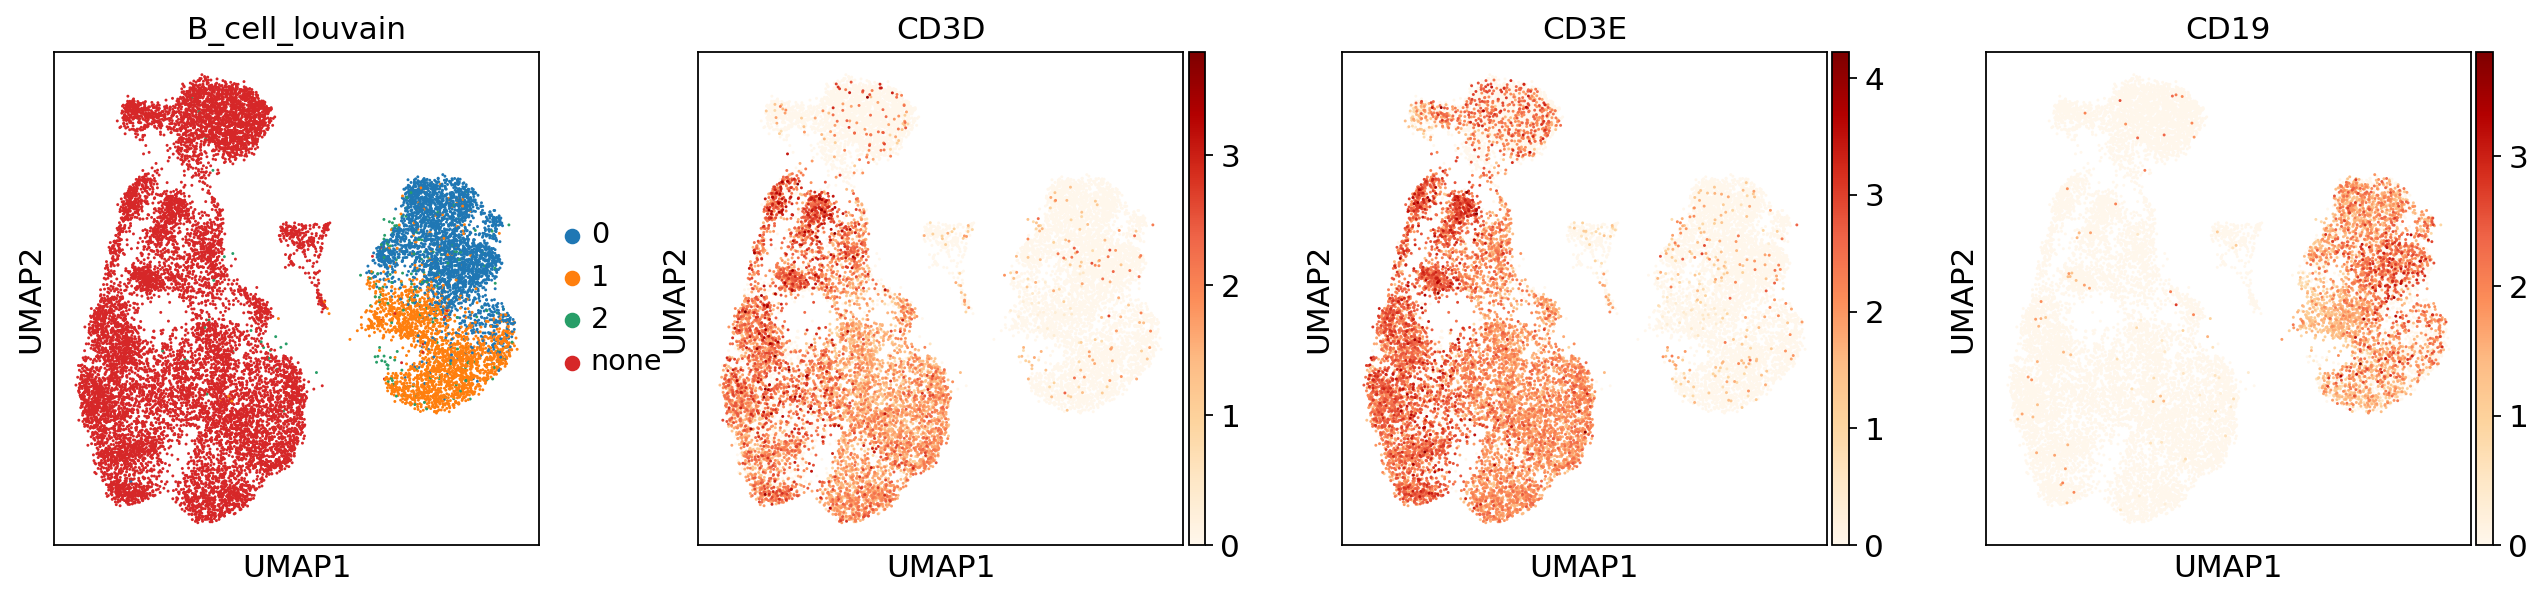

In [69]:
sc.pl.umap(adata_with_annot, color=['B_cell_louvain','CD3D','CD3E','CD19'],
          cmap='OrRd', use_raw=True)

# cluster 2 is B:T cell doublets - to be removed - cleaned up general manifold calculation in M7 notebook and for B cell manifold - S1 notebook

In [53]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

In [60]:
adata_hvg.write(save_path+'adata_hvg_BBKNN_by_sample_nodoublets_B_cells.h5ad')

In [226]:
adata_hvg = sc.read(save_path+'adata_hvg_BBKNN_by_sample_nodoublets_B_cells.h5ad')